In [1]:
from IPython.core.display import HTML
with open('../style.css') as f:
    css = f.read()
HTML(css)

# Consistency Checking

## Utility Functions

The module `extractVariables` implements the function $\texttt{extractVars}(e)$ that takes a *Python* expression $e$ as its argument and returns the set of all variables and function names occurring in $e$.

In [2]:
import extractVariables as ev

The function `collect_variables(expr)` takes a string `expr` that can be interpreted as a Python expression as input and collects all variables occurring in `expr`.  It takes care to eliminate the function symbols from the names returned by `extract_variables`.

In [3]:
def collect_variables(expr):
    return frozenset(var for var in ev.extractVars(expr)
                         if  var not in dir(__builtins__)
                         if  var not in ['and', 'or', 'not']
                    )

The function `arb(S)` takes a set `S` as input and returns an arbitrary element from 
this set.

In [4]:
def arb(S):
    for x in S:
        return x

Backtracking is simulated by raising the `Backtrack` exception.  We define this new class of exceptions so that we can distinguish `Backtrack` exceptions from ordinary exceptions.  This is done by creating a new, empty class that is derived from the class `Exception`.  

In [5]:
class Backtrack(Exception):
    pass

Given a list of sets `L`, the function `union(L)` returns the set of all elements occurring in some set $S$ that is itself a member of the list `L`, i.e. we have
$$ \texttt{union}(L) = \{ x \mid \exists S \in L : x \in L \}. $$ 

In [6]:
def union(L):
    return { x for S in L
               for x in S
           }

In [7]:
union([ {1, 2}, {'a', 'b'}, {1, 'a'} ])

{1, 2, 'a', 'b'}

## A Constraint Propagation Solver with Consistency Maintenance

The procedure `solve(P, check_consistency)` takes two arguments:
* `P` is a *constraint satisfaction problem* 
  Here `P` is a triple of the form 
  $$ \mathcal{P} = \langle \mathtt{Variables}, \mathtt{Values}, \mathtt{Constraints} \rangle $$
  where 
  - $\mathtt{Variables}$ is a set of strings which serve as *variables*,
  - $\mathtt{Values}$ is a set of *values* that can be assigned 
    to the variables in the set $\mathtt{Variables}$.
  - $\mathtt{Constraints}$ is a set of *formulas* from first order logic.  
    Each of these formulas is  called a *constraint* of $\mathcal{P}$.
* `check_consistency` is a Boolean flag.  If this flag is `True`, then *consistency maintenance* is used
  as a preprocessing step.

Before trying to solve the given CSP, `solve` checks whether the set of variables occurring in
the constraints is the same as the set `Variables`.  If this is not the case, then this is most likely due to
a spelling error and a warning message is printed.  Then, the function `solve` converts the CSP `P` into an *augmented CSP* where every constraint $f$ is annotated with the variables occurring in $f$.  Furthermore, the function solve maintains the following data structures:

- `VarsInConstrs` is the set of all variables occurring in any constraint.
- `ValuesPerVar` is a dictionary mapping variables to sets of values.  For every variable `x` occurring in a constraint of `P`, the expression `ValuesPerVar[x]` is the set of values that can be used to instantiate the variable `x`.  Initially, `ValuesPerVar[x]` is set to `Values`, but as the search for a solution proceeds, the sets `ValuesPerVar[x]` are reduced by removing any values that cannot be part of a solution.
- `Annotated` is a dictionary.  For every constraint `f` we have that `Annotated[f]` is the set of all variables occurring in `f`.
- `UnaryConstrs` is a set of pairs of the form `(f, V)` where `f` is a constraint containing only a single variable and `V` is the set containing just this variable.
- `OtherConstrs` is a set of pairs of the form `(f, V)` where `f` is a constraint containing more than one variable and `V` is the set of all variables occurring in `f`.
- `Connected` is a dictionary mapping variables to sets of variables.  If `x` is a variable, then  `Connected[x]` is the set of those variables `y` such that there is a constraint `f` that mentions both the variable `x` and the variable `y`.
- `Var2Formulas` is a dictionary mapping variables to sets of formulas.  For every variable `x`, `Var2Formulas[x]` is the set of all those non-unary constraints `f` such that `x` occurs in `f`.

The unary constraints are immediately solved.  After that, the function `enforce_consistency` performs 
*consistency maintenance*:  
Formally, we define that a value $v$ is *consistent* for a variable $x$ with respect to a constraint $f$
iff the partial assignment $\{ x \mapsto v \}$ can be extended to an assignment $A$ satisfying the constraint $f$,
i.e. for every variable $\texttt{y}_i$ occurring in `f` there is a value $w_i \in \texttt{ValuesPerVar}[y]$ such that  
$$ \texttt{eval}\bigl(f, \{ x \mapsto v, y_1 \mapsto w_1, \cdots, y_n \mapsto w_n\}\bigr) = \texttt{True}. $$
The call to `enforce_consistency` shrinks the sets `ValuesPerVars[x]` until all values in `ValuesPerVars[x]`
are consistent with respect to all constraints.

Finally, `backtrack_search` is called to solve the remaining constraint satisfaction problem by the means of both *backtracking* and
*constraint propagation*.  Furthermore, the *most constrained variable* heuristic and the *least constraining value* heuristic are used.

In [8]:
def solve(P, check_consistency=True, lcv=False):
    Variables, Values, Constraints = P
    VarsInConstrs  = union([ collect_variables(f) for f in Constraints ])
    MisspelledVars = (VarsInConstrs - Variables) | (Variables - VarsInConstrs)
    if len(MisspelledVars) > 0:
        print("Did you misspell any of the following Variables?")
        for v in MisspelledVars:
            print(v)
    ValuesPerVar = { x: Values for x in Variables }
    Annotated    = { f: collect_variables(f) for f in Constraints }
    UnaryConstrs = { (f, V) for f, V in Annotated.items() if len(V) == 1 }
    OtherConstrs = { (f, V) for f, V in Annotated.items() if len(V) >= 2 }
    Connected    = {}
    Var2Formulas = variables_2_formulas(OtherConstrs)
    for x in Variables:
        Connected[x] = union([ V for f, V in Annotated.items() if x in V ]) - { x }
    try:
        for f, V in UnaryConstrs:
            var               = arb(V)
            ValuesPerVar[var] = solve_unary(f, var, ValuesPerVar[var])
        if check_consistency:
            enforce_consistency(ValuesPerVar, Var2Formulas, Annotated, Connected)
            for x, Values in ValuesPerVar.items():
                print(f'{x}: {Values}')
        return backtrack_search({}, ValuesPerVar, OtherConstrs, lcv)
    except Backtrack:
        return None

The function `variables_2_formulas` takes a set of *annotated constraints* as input.  An *annotated constraint* is a pair of the form
`(f, V)` where `f` is a formula and `V` is the set of variables occurring in `f`.  The function returns
a dictionary that maps every variable `x` to the set of those constraints `f` such that `x` occurs in `f`.

In [9]:
def variables_2_formulas(Constraints):
    Dictionary = {}
    for f, Vars in Constraints:
        for x in Vars: 
            if x in Dictionary: # Dictionary[x] is already defined
                Dictionary[x] |= { f }
            else:               # Dictionary[x] is not yet defined
                Dictionary[x]  = { f }
    return Dictionary

The function `enforce_consistency` takes 4 arguments:
- `ValuesPerVar` is a dictionary.  For every variable `x` we have that `ValuesPerVar[x]` is the set of values that can be substituted for `x`.
- `Var2Formulas`is a dictionary.  For every variable `x` we have that `Var2Formulas[x]` is the set of those formulas that mention the variable `x`.
- `Annotated` is a dictionary.  For every constraint `F`, `Annotated[F]` is the set of variables occurring in `F`.
- `Connected` is a dictionary.  For every variable `x` we have that `Connected[x]` is the set of those variables `y` that are *directly connected* with the variable `x`.  Two variables `x` and `y` are *directly connected* if there is a constraint `F` such that both `x` and `y` occur in `F`.  In this case, `F` is *connecting* `x` and `y`.

The function `enforce_consistency`shrinks the sets `ValuesPerVar[x]` such that the values in `ValuesPerVar[x]` are consistent for `x` for all constraints.

In [10]:
def enforce_consistency(ValuesPerVar, Var2Formulas, Annotated, Connected):
    UncheckedVars = set(Var2Formulas.keys())
    while UncheckedVars:
        variable    = UncheckedVars.pop()
        Constraints = Var2Formulas[variable]
        Values      = ValuesPerVar[variable]
        RemovedVals = set()
        for f in Constraints:
            OtherVars = Annotated[f] - { variable }
            for value in Values:
                if not exists_values(variable, value, f, OtherVars, ValuesPerVar):
                    RemovedVals   |= { value }
                    UncheckedVars |= Connected[variable]
        Remaining = Values - RemovedVals
        if len(Remaining) == 0: # the problem is unsolvable
            raise Backtrack()  
        ValuesPerVar[variable] = Remaining

The procedure `exists_values` takes five arguments:
- `var` is a variable, 
- `val` is a value val, 
- `f`   is a constraint,
- `Vars` is the set Vars of those variables in f that are different from `var`, and
- `ValuesPerVar` is a dictionary.  For every variable `x` we have that `ValuesPerVar[x]` is the set of those values that still may be tried for `x`.

The function checks whether there is a value for `var` such that the other variables occurring in the constraint `f` can be set to values such that the constraint `f` is satisfied.

In [11]:
def exists_values(var, val, f, Vars, ValuesPerVar):
    Assignments = all_assignments(set(Vars), ValuesPerVar)
    return any(eval(f, extend(A, var, val)) for A in Assignments)

The function `extend` takes three arguments:
- `A` is a dictionary,
- `x` is a variable such that `A[x]`is not yet defined,
- `v`is some value.

It returns a new dictionary `B` such that `B[x] = v` and `B[y] = A[y]` for all `y != x`.

In [12]:
def extend(A, x, v):
    B = A.copy()
    B[x] = v
    return B

The function `all_assignments` returns the list of all possible assignments for the variables in the set Vars.
For every variable `x`, the values for `x` are taken from `ValuesPerVar[x]`.

In [13]:
def all_assignments(Variables, ValuesPerVar):
    if not Variables:
        return [ {} ]  # list containing empty assignment
    var         = Variables.pop()
    Values      = ValuesPerVar[var]
    Assignments = all_assignments(Variables, ValuesPerVar)
    return [ extend(A, var, val) for A in Assignments 
                                 for val in ValuesPerVar[var]
           ]

In [14]:
ValuesPerVar = { 'x': {1, 2}, 'y': {2, 3} }
Variables    = { 'x', 'y' }
all_assignments(Variables, ValuesPerVar)

[{'x': 1, 'y': 2}, {'x': 1, 'y': 3}, {'x': 2, 'y': 2}, {'x': 2, 'y': 3}]

The function `solve_unary` takes a unary constraint `f`, a variable `x` and the set of values `Values` that can be assigned to `x`.  It returns the subset of values that can be substituted for `x` such that $f[x\mapsto v]$ evaluates as `True`.

In [15]:
def solve_unary(f, x, Values):
    Legal = { value for value in Values if  eval(f, { x: value }) }
    if len(Legal) == 0:
        raise Backtrack()
    return Legal

The function `backtrack_search` takes three arguments:
- `Assignment` is a partial variable assignment that is represented as a
   dictionary.  Initially, this assignment will be the  empty dictionary.     
   Every recursive call of `backtrack_search` adds the assignment of one 
   variable to  the given assignment. 
- `ValuesPerVar` is a dictionary.  For every variable `x`, `ValuesPerVar[x]` is the set of values that still might be assigned to `x`.
- `Constraints` is a set of pairs of the form `(f, V)` where `f` is a constraint and `V` is the set of variables occurring in `f`.

The function `backtrack_search` uses the *most constrained variable heuristic* in order to choose the next variable.  It uses the *least constraining value heuristic* to choose the value that is asigned to this variable.

In [16]:
def backtrack_search(Assignment, ValuesPerVar, Constraints, lcv):
    if len(Assignment) == len(ValuesPerVar):
        return Assignment
    x = most_constrained_variable(Assignment, ValuesPerVar)
    if lcv and len(ValuesPerVar[x]) > 1:
        ValueList = least_constraining(x, ValuesPerVar, Assignment, Constraints)
    else:
        ValueList = ValuesPerVar[x]
    for v in ValueList:
        try:
            NewValues = propagate(x, v, Assignment, Constraints, ValuesPerVar)
            NewAssign = Assignment.copy()
            NewAssign[x] = v
            return backtrack_search(NewAssign, NewValues, Constraints, lcv)
        except Backtrack:
            continue
    raise Backtrack()

The function `most_constrained_variable` takes two parameters:
- `Assigment` is a *partial variable assignment* that assigns values to variables.  It is represented as a dictionary.
- `ValuesPerVar` is a dictionary that has variables as keys.  For every variable `x`, `ValuesPerVar[x]` is the set of values that 
  can still be assigned to the variable `x`.
  
The function returns an unassigned variable `x` such that the number of values in `ValuesPerVar[x]` is minimal among all other unassigned variables.
Hence, this variable is a *most constraint variable*.  
* In order to find this variable, the set `Unassigned` is computed.  This is a set of pairs of the form `(x, n)` 
  where `x` is a variable that is not yet assigned and `n` is the number of values that can still be assigned to `x`.
* `minSize` is the number of values that can be assigned to a most constrained variable.  

In [17]:
def most_constrained_variable(Assignment, ValuesPerVar):
    Unassigned = { (x, len(U)) for x, U in ValuesPerVar.items()
                               if  x not in Assignment
                 }
    minSize = min(lenU for x, lenU in Unassigned)
    for x, lenU in Unassigned:
        if lenU == minSize:
            return x

The module `math` is needed because it provides `math.inf`, which represents $\infty$. 

In [18]:
import math

The function `least_constraining` takes four arguments:
* `x` is a variable. 
* `ValuesPerVar` is a dictionary.  For every variable `var`, `ValuesPerVar[var]` is the set of values that can be assigned to `var`.
* `Assignment` is a partial variable assignment.
* `Constraints` is a set of annotated constraints.

This function returns a list of values that can be substituted for the variable `x`.  
This list is sorted so that the *least constraining* values are at the beginning of this list. 

In [19]:
def least_constraining(x, ValuesPerVar, Assignment, Constraints):
    NumbersValues = []
    for value in ValuesPerVar[x]:
        num_removed = number_removed_values(x, value, Assignment, ValuesPerVar, Constraints)
        if num_removed != math.inf:
            NumbersValues.append( (num_removed, value) )
    NumbersValues.sort(key=lambda p: p[0])
    return [val for _, val in NumbersValues]

The function `number_removed_values` takes 5 arguments:
- `x` is a variable that has not yet been assigned a value.
- `value` is a value that is to be assigned to the variable `x`.
- `Assignment` is a partial variable assignment that does not assign a value to `x`.
- `ValuesPerVar` is a dictionary that has variables as keys.  For every variable `x`, `ValuesPerVar[x]` is the set of values that 
  can still be assigned to the variable `x`.
- `Constraints` is a set of pairs of the form `(f, V)` where `f` is a constraint and `V` is the set of variables occurring in `f`.

This function returns the number of values that need to be removed from the set `ValuesPerVar[y]` for those variables `y` that are 
different from `x` if we assign `value` to the variable `x`.  If the assignment `{ x: value }` results in any of the sets `ValuesPerVar[y]`
becomming empty, then the function returns `math.inf` in order to signal that the the assignment `{ x: value }` leads to an unsolvable problem.

In [20]:
def number_removed_values(x, value, Assignment, ValuesPerVar, Constraints):
    count     = 0   # number of values removed from ValuesPerVar
    BoundVars = set(Assignment.keys())
    for f, Vars in Constraints:
        if x in Vars:
            UnboundVars = Vars - BoundVars - { x }
            if len(UnboundVars) == 1:
                y = arb(UnboundVars)
                Legal = set()
                for w in ValuesPerVar[y]:
                    NewAssign = Assignment.copy()
                    NewAssign[x] = value
                    NewAssign[y] = w
                    if eval(f, NewAssign):
                        Legal.add(w)
                    else:
                        count += 1
                if len(Legal) == 0:
                    count = math.inf
    return count           

The function `propagate` takes five arguments:
- `x` is a variable,
- `v` is a value that is supposed to be assigned to `x`.
- `Assignment` is a partial assignment that contains assignments for variables that are different from `x`.
- `Constraints` is a set of annotated constraints.
- `ValuesPerVar` is a dictionary assigning sets of values to all variables.  For every unassigned variable `z`,  `ValuesPerVar[z]` is the set of values that still might be assigned to `z`.

The purpose of the function  `propagate` is to compute how the sets `ValuesPerVar[z]` can be shrunk when the value `v` is assigned to the variable `x`.  The dictionary `ValuesPerVar` with appropriately reduced sets `ValuesPerVar[z]` is returned.

In [21]:
def propagate(x, v, Assignment, Constraints, ValuesPerVar):
    ValuesDict = ValuesPerVar.copy()
    ValuesDict[x] = { v }
    BoundVars = set(Assignment.keys())
    for F, Vars in Constraints:
        if x in Vars:
            UnboundVars = Vars - BoundVars - { x }
            if len(UnboundVars) == 1:
                y = arb(UnboundVars)
                Legal = set()
                for w in ValuesDict[y]:
                    NewAssign = Assignment.copy()
                    NewAssign[x] = v
                    NewAssign[y] = w
                    if eval(F, NewAssign):
                        Legal.add(w)
                if len(Legal) == 0:
                    raise Backtrack()
                ValuesDict[y] = Legal
    return ValuesDict

## Solving the *Eight-Queens-Puzzle*

In [23]:
%%capture
%run N-Queens-Problem-CSP.ipynb

In [24]:
P = create_csp(8)

The consistency solver takes about 38 milliseconds on my desktop to solve the eight queens puzzle.  Hence, for the eight queens puzzle, consistency maintenance does not help.

In [25]:
%%time
Solution = solve(P, check_consistency=True)
print(f'Solution = {Solution}')

V1: {1, 2, 3, 4, 5, 6, 7, 8}
V4: {1, 2, 3, 4, 5, 6, 7, 8}
V6: {1, 2, 3, 4, 5, 6, 7, 8}
V5: {1, 2, 3, 4, 5, 6, 7, 8}
V8: {1, 2, 3, 4, 5, 6, 7, 8}
V7: {1, 2, 3, 4, 5, 6, 7, 8}
V3: {1, 2, 3, 4, 5, 6, 7, 8}
V2: {1, 2, 3, 4, 5, 6, 7, 8}
Solution = {'V2': 1, 'V5': 2, 'V8': 6, 'V6': 7, 'V7': 3, 'V4': 8, 'V1': 4, 'V3': 5}
Wall time: 32 ms


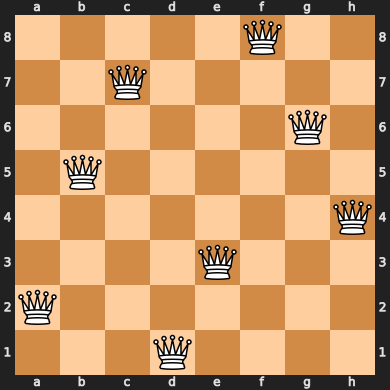

In [26]:
show_solution(Solution)

In [27]:
%%time
Solution = solve(P, check_consistency=False)
print(f'Solution = {Solution}')

Solution = {'V2': 1, 'V5': 2, 'V8': 6, 'V6': 7, 'V7': 3, 'V4': 8, 'V1': 4, 'V3': 5}
Wall time: 17 ms


In [28]:
P = create_csp(32)

The 32-queens-problem can be solved in 1 second.

In [29]:
%%time
Solution = solve(P, check_consistency=True)
print(f'Solution = {Solution}')

V14: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32}
V11: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32}
V16: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32}
V26: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32}
V19: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32}
V3: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32}
V23: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32}
V2: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32}
V2

## Solving the *Zebra Puzzle*

In [30]:
%run Zebra.ipynb

In [31]:
zebra = zebra_csp()

The consistency solver takes about 11 milliseconds to solve the *zebra puzzle* without consistency maintenance.

In [32]:
%%time
Solution = solve(zebra, check_consistency=False)

Wall time: 13 ms


In [33]:
show_solution(Solution)

House,Nationality,Drink,Animal,Brand,Colour
1,Norwegian,Water,Fox,Kools,Yellow
2,Ukrainian,Tea,Horse,Chesterfields,Blue
3,English,Milk,Snails,OldGold,Red
4,Spanish,OrangeJuice,Dog,LuckyStrike,Ivory
5,Japanese,Coffee,Zebra,Parliaments,Green


For the *Zebra puzzle*, *consistency maintenance* does not decrease the running time.

In [34]:
%%time
Solution = solve(zebra, check_consistency=True)

Fox: {1, 2, 3, 4, 5}
Ukrainian: {2, 4, 5}
Yellow: {1, 3, 4, 5}
LuckyStrike: {1, 2, 4, 5}
Red: {3, 4, 5}
OrangeJuice: {1, 2, 4, 5}
English: {3, 4, 5}
Tea: {2, 4, 5}
Zebra: {1, 2, 3, 4, 5}
Horse: {2, 3, 4, 5}
Blue: {2}
Water: {1, 2, 4, 5}
Spanish: {2, 3, 4, 5}
Parliaments: {2, 3, 4, 5}
Norwegian: {1}
Milk: {3}
Snails: {1, 2, 3, 4, 5}
Coffee: {4, 5}
Chesterfields: {1, 2, 3, 4, 5}
Ivory: {3, 4}
OldGold: {1, 2, 3, 4, 5}
Kools: {1, 3, 4, 5}
Japanese: {2, 3, 4, 5}
Green: {4, 5}
Dog: {2, 3, 4, 5}
Wall time: 28 ms


## Solving a Sudoku Puzzle

In [35]:
%run Sudoku.ipynb

In [36]:
csp = sudoku_csp(Sudoku)

In [37]:
%%time
Solution = solve(csp, check_consistency=False)

Wall time: 117 ms


In [38]:
show_solution(Solution)

Canvas(height=360, width=360)

For the sudoku, consistency maintenance does not decrease the running time.

In [39]:
%%time
Solution = solve(csp, check_consistency=True)

V78: {3, 6}
V14: {8, 1, 4}
V77: {3, 7}
V51: {1, 2, 3, 9}
V11: {8, 1, 2, 4}
V41: {8, 1, 4, 9}
V58: {1, 3, 6}
V64: {8, 1, 9}
V65: {1, 2, 7, 8, 9}
V68: {1, 3}
V16: {8, 1, 2, 4}
V26: {8, 1}
V59: {9, 5, 6}
V63: {2, 3, 4, 7, 8}
V67: {9, 3}
V81: {8, 9, 3, 6}
V94: {8, 1, 3, 4}
V95: {8, 1, 3}
V23: {8, 6}
V98: {2, 3, 6}
V84: {8, 3, 5}
V93: {8, 3, 4, 6}
V52: {1, 9, 7}
V54: {1, 5, 9}
V99: {8, 9, 6}
V21: {8, 1, 6}
V87: {9, 3, 7}
V49: {9, 4, 5}
V43: {8, 4}
V42: {8, 1, 4, 9}
V56: {1, 2, 7}
V37: {1}
V66: {8, 1, 2, 7}
V18: {5}
V15: {8, 1, 2}
V53: {2, 3, 7}
V89: {8, 9, 6}
V17: {6}
V22: {8, 1, 5}
V86: {8, 6, 7}
V75: {8, 3, 7}
V33: {2, 4, 7}
V34: {9, 4}
V25: {8, 1, 3}
V69: {9, 4}
V85: {8, 3, 5, 7}
V45: {8, 1, 5, 9}
V92: {8, 9, 4}
V72: {8, 4}
V71: {8, 3, 4, 6}
V32: {4, 7}
V31: {2, 4}
V96: {8, 1, 4, 6}
Wall time: 165 ms


## Solving a Crypto-Arithmetic Puzzle

In [40]:
%run Crypto-Arithmetic.ipynb

In [41]:
csp = crypto_csp()

With *consistency checking* the time to solve the crypto arithmetic puzzle is reduced to less than 200 milliseconds.

In [42]:
%%time
Solution = solve(csp, check_consistency=True)

O: {0, 9}
R: {0, 2, 3, 4, 5, 6, 7, 8, 9}
C1: {0, 1}
M: {1}
Y: {0, 2, 3, 4, 5, 6, 7, 8, 9}
C2: {0, 1}
N: {0, 2, 3, 4, 5, 6, 7, 8, 9}
D: {0, 2, 3, 4, 5, 6, 7, 8, 9}
C3: {0, 1}
E: {0, 2, 3, 4, 5, 6, 7, 8, 9}
S: {8, 9}
Wall time: 232 ms


In [43]:
show_solution(Solution)

O = 0
R = 8
M = 1
Y = 2
N = 6
D = 7
E = 5
S = 9

The solution of

    S E N D
  + M O R E
  ---------
  M O N E Y

is as follows

    9 5 6 7
  + 1 0 8 5
  1 0 6 5 2


In [44]:
%%time
Solution = solve(csp, check_consistency=False)

Wall time: 1.76 s


In [45]:
csp = crypto_csp_hard()
csp

({'C1', 'C2', 'C3', 'D', 'E', 'M', 'N', 'O', 'R', 'S', 'Y'},
 {0, 1, 2, 3, 4, 5, 6, 7, 8, 9},
 {'D != E',
  'D != M',
  'D != N',
  'D != O',
  'D != R',
  'D != S',
  'D != Y',
  'D + E      == C1 * 10 + Y',
  'E != M',
  'E != N',
  'E != O',
  'E != R',
  'E != S',
  'E != Y',
  'E + O + C2 == C3 * 10 + N',
  'M != 0',
  'M != N',
  'M != O',
  'M != R',
  'M != S',
  'M != Y',
  'N != O',
  'N != R',
  'N != S',
  'N != Y',
  'N + R + C1 == C2 * 10 + E',
  'O != R',
  'O != S',
  'O != Y',
  'R != S',
  'R != Y',
  'S != 0',
  'S != Y',
  'S + M + C3 ==  M * 10 + O'})

In [46]:
%%time
Solution = solve(csp, check_consistency=True)

O: {0}
R: {2, 3, 4, 5, 6, 7, 8}
C1: {0, 1}
M: {1}
Y: {2, 3, 4, 5, 6, 7, 8}
C2: {0, 1}
N: {2, 3, 4, 5, 6, 7, 8}
D: {2, 3, 4, 5, 6, 7, 8}
C3: {0}
E: {2, 3, 4, 5, 6, 7, 8}
S: {9}
Wall time: 831 ms


For the hard version of the crypto-arithmetic puzzle, *consistency maintenance* decreases the total running time.

In [47]:
%%time
Solution = solve(csp, check_consistency=False)

Wall time: 5.17 s
